<a href="https://colab.research.google.com/github/SrinijaB-05/SafeStreet-1/blob/main/Image_preprocessing_RNECS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ViT preprocessing available but not displayed in plot


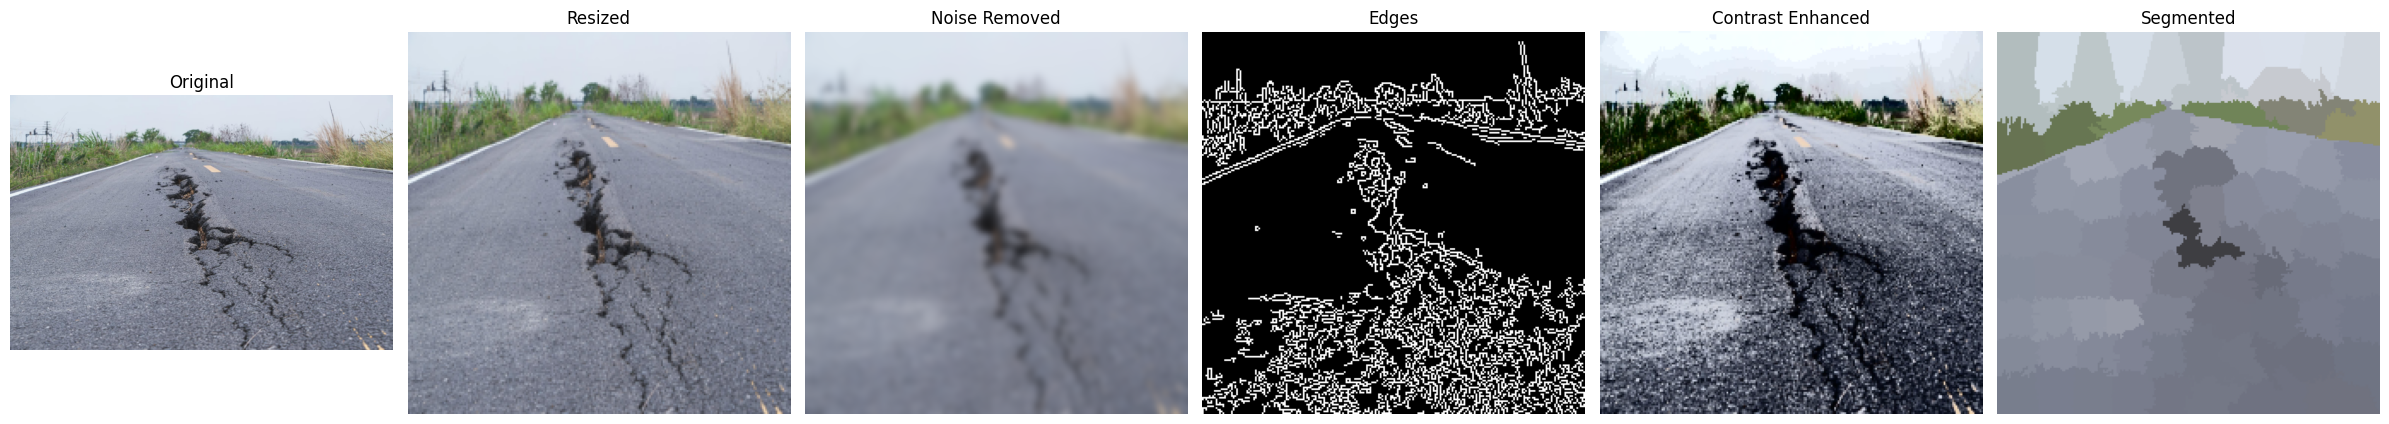

ViT tensor shape: torch.Size([3, 224, 224])
ViT features: dict_keys(['pixel_values'])


In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
from skimage.filters import gaussian
from skimage.segmentation import slic
from skimage.color import label2rgb
from transformers import ViTFeatureExtractor

def load_image(image_path):
    """Load an image from file path"""
    # Original image (no processing)
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return img_rgb

def resize_image(image, target_size=(224, 224)):
    """Resize image to target dimensions"""
    # Processed: Image dimensions changed to target_size
    # Purpose: Standardize input size for models, reduce computation
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def remove_noise(image, method='gaussian', strength=2):
    """Remove noise from image using different filtering methods"""
    # Processed: Noise patterns reduced or eliminated
    # Purpose: Improve signal-to-noise ratio, prevent false feature detection

    if method == 'gaussian':
        # Use channel_axis instead of multichannel for newer skimage versions
        return gaussian(image, sigma=strength, channel_axis=-1)
    elif method == 'median':
        return cv2.medianBlur(image, ksize=strength*2+1)
    elif method == 'bilateral':
        return cv2.bilateralFilter(image, d=strength*5, sigmaColor=75, sigmaSpace=75)
    else:
        raise ValueError(f"Unknown noise removal method: {method}")

def detect_edges(image, method='canny'):
    """Detect edges in the image"""
    # Processed: Edge pixels highlighted, non-edges suppressed
    # Purpose: Identify boundaries between objects, shape detection

    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        gray = image.astype(np.uint8)

    if method == 'canny':
        return cv2.Canny(gray, 50, 150)
    elif method == 'sobel':
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return np.sqrt(sobel_x**2 + sobel_y**2).astype(np.uint8)
    elif method == 'laplacian':
        return cv2.Laplacian(gray, cv2.CV_64F).astype(np.uint8)
    else:
        raise ValueError(f"Unknown edge detection method: {method}")

def enhance_contrast(image, method='histogram_equalization'):
    """Enhance contrast in the image"""
    # Processed: Pixel intensity distribution modified
    # Purpose: Improve visibility of features, highlight details

    if method == 'histogram_equalization':
        # For RGB images, apply to each channel separately
        if len(image.shape) == 3:
            img_yuv = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2YUV)
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        else:
            return cv2.equalizeHist(image.astype(np.uint8))
    elif method == 'clahe':
        # Create a CLAHE object
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        if len(image.shape) == 3:
            img_yuv = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2YUV)
            img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
            return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        else:
            return clahe.apply(image.astype(np.uint8))
    else:
        raise ValueError(f"Unknown contrast enhancement method: {method}")

def segment_image(image, method='slic', n_segments=100):
    """Segment the image into regions"""
    # Processed: Image divided into meaningful regions or objects
    # Purpose: Group pixels by similarity for object recognition, scene understanding

    if method == 'slic':
        segments = slic(image, n_segments=n_segments, compactness=10)
        return label2rgb(segments, image, kind='avg')
    elif method == 'watershed':
        # Convert to grayscale
        gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
        # Apply threshold
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        # Noise removal
        kernel = np.ones((3,3), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        # Sure background area
        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        # Marker labelling
        _, markers = cv2.connectedComponents(sure_fg)
        # Add one to all labels so that background is not 0, but 1
        markers = markers + 1
        # Mark the region of unknown with zero
        markers[unknown == 255] = 0
        markers = cv2.watershed(image.astype(np.uint8), markers)
        image[markers == -1] = [255, 0, 0]  # Mark boundaries in red
        return image
    else:
        raise ValueError(f"Unknown segmentation method: {method}")

def vit_preprocess(image_path, feature_extractor_name="google/vit-base-patch16-224"):
    """
    Preprocess image for Vision Transformer (ViT) model
    Returns both the preprocessed tensor and the features from the ViT feature extractor
    """
    # Processed: Image normalized and formatted for deep learning
    # Purpose: Prepare image for ViT model input, extract learned features

    # Load image with PIL (required by feature extractor)
    image = Image.open(image_path).convert("RGB")

    # Standard preprocessing for PyTorch models
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Get tensor for regular PyTorch models
    tensor = preprocess(image)

    # Get features using the ViT feature extractor
    feature_extractor = ViTFeatureExtractor.from_pretrained(feature_extractor_name)
    features = feature_extractor(images=image, return_tensors="pt")

    return {
        "tensor": tensor,  # Normalized tensor in PyTorch format [3, 224, 224]
        "features": features  # Features from ViT feature extractor
    }

def display_results(original, processed_dict):
    """Display original and processed images side by side"""
    n_images = len(processed_dict) + 1
    fig, axes = plt.subplots(1, n_images, figsize=(4*n_images, 5))

    # Display original
    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Display processed images
    for i, (title, img) in enumerate(processed_dict.items(), 1):
        if len(img.shape) == 2:  # Grayscale
            axes[i].imshow(img, cmap='gray')
        else:  # Color
            axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def main(image_path):
    """Run the complete preprocessing pipeline on an image"""
    # Load original image
    original = load_image(image_path)

    # Initialize dictionary to store processed images
    processed = {}

    # Apply each preprocessing step
    processed["Resized"] = resize_image(original)
    processed["Noise Removed"] = remove_noise(processed["Resized"], method='gaussian')
    processed["Edges"] = detect_edges(processed["Resized"])
    processed["Contrast Enhanced"] = enhance_contrast(processed["Resized"])
    processed["Segmented"] = segment_image(processed["Resized"])

    # For ViT preprocessing, we just mention it's available
    # (can't display tensor directly in the same way)
    print("ViT preprocessing available but not displayed in plot")

    # Display results
    display_results(original, processed)

    # Return both original and processed images
    return original, processed

if __name__ == "__main__":
    # Example usage
    image_path = "/content/ROAD.jpg"
    original, processed = main(image_path)

    # To demonstrate the ViT preprocessing separately
    vit_data = vit_preprocess(image_path)
    print(f"ViT tensor shape: {vit_data['tensor'].shape}")
    print(f"ViT features: {vit_data['features'].keys()}")